In [82]:
# Libraries

# Agent-based modeling
import mesa

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd

# Calculations
import math

In [83]:
## metrics used

# gini index
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

# (A) sensitive attribute
    # individuals from group A1
    # infividiuals from group A2

# company's cost increase as they provide service to more areas
# areas where A1 live have a higher earning, which is why company discriminates 
    # addition will be made: company will make more money if they provide service to A1 areas

# Fair Scenario

In [84]:
# this will be added to the model, essentially it's the same as the step k case with k = 0 (Check bottom)

# Discrimination Scenario

We use square root utility function for diminishing marginal utility.


In [85]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

In [86]:
class MoneyAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_neighborhood):
        super().__init__(unique_id, model)
        self.wealth = 1
        self.life_quality = 0.1  # Initialize life quality
        self.initial_neighborhood = initial_neighborhood  # Track initial neighborhood

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 0.0001 * (1 + other.life_quality)
            self.wealth -= 0.0001

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods, life_qual_multiplier):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.life_qual_multiplier = life_qual_multiplier
        self.profit_current = 0.01  # Initialize profit_current
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    if agent.initial_neighborhood == "Non-Discriminated":
                        # Provide service to agents whose initial neighborhood is not discriminated
                        agent.life_quality = math.sqrt(agent.life_quality * (1 + self.life_qual_multiplier))
                        profit += (10*(self.profit_current**2) /(100 + self.profit_current**3))   # Calculate profit for this agent using profit_current
                        cost += 0.001  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)
        self.profit_current += 0.1  # Update profit_current with the profit calculated for this step

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [87]:
# Define MoneyModelWithCompany class
class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods, life_qual_multiplier):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods, life_qual_multiplier)  # Include life_qual_multiplier

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "CompanyProfit": lambda m: m.company.profit},
            agent_reporters={"Wealth": "wealth",
                             "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

In [88]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.0001

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(2000):
    model.step()  # Step the model

/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_43461/2041198889.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [89]:
# Calculate the profit of the company
total_profit = model.company.calculate_total_profit()
print("Total Profit:", total_profit)

Total Profit: 18715.323387224547


In [90]:
model_data = model.datacollector.get_model_vars_dataframe()


In [91]:
model_data

,Gini,CompanyProfit
0,0.000000,"[0.0004999999949999998, 0.06049919475571778, 0..."
1,0.000041,"[0.0004999999949999998, 0.06049919475571778, 0..."
2,0.000061,"[0.0004999999949999998, 0.06049919475571778, 0..."
3,0.000081,"[0.0004999999949999998, 0.06049919475571778, 0..."
4,0.000091,"[0.0004999999949999998, 0.06049919475571778, 0..."
...,...,...
1995,0.012644,"[0.0004999999949999998, 0.06049919475571778, 0..."
1996,0.012653,"[0.0004999999949999998, 0.06049919475571778, 0..."
1997,0.012651,"[0.0004999999949999998, 0.06049919475571778, 0..."
1998,0.012657,"[0.0004999999949999998, 0.06049919475571778, 0..."


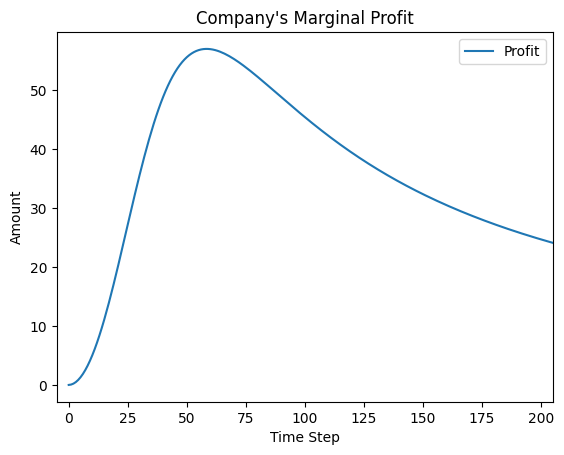

'# Assuming you have already run the model and collected data\n# Get the profit data from the data collector\nmodel_data = model.datacollector.get_model_vars_dataframe()\n\n# Plot the profit over time\nplt.figure(figsize=(10, 6))\nsns.lineplot(data=model_data["CompanyProfit"])\nplt.title("Company Profit over Time")\nplt.xlabel("Steps")\nplt.ylabel("Profit")\nplt.show()\n'

In [92]:
# Plot the company's marginal profit over time
marginal_profit = model.company.profit
plt.plot(range(2000), marginal_profit, label="Profit")
#plt.plot(range(200), model.company.cost, label="Cost")
plt.xlabel("Time Step")
plt.ylabel("Amount")
plt.title("Company's Marginal Profit")
plt.legend()
plt.xlim(-5, 205)

plt.show()

'''# Assuming you have already run the model and collected data
# Get the profit data from the data collector
model_data = model.datacollector.get_model_vars_dataframe()

# Plot the profit over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=model_data["CompanyProfit"])
plt.title("Company Profit over Time")
plt.xlabel("Steps")
plt.ylabel("Profit")
plt.show()
'''

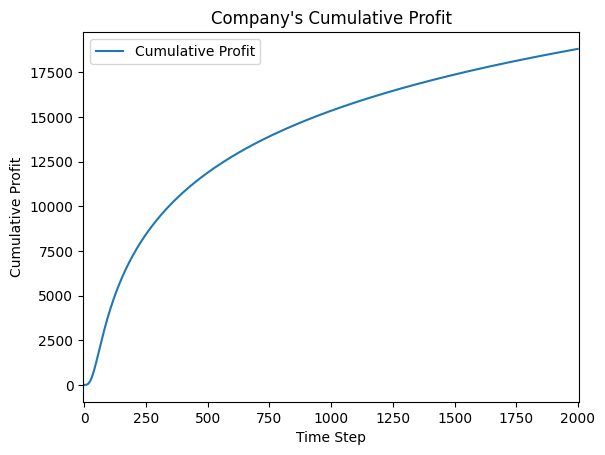

In [93]:
# Plot the company's profit over time
marginal_profit = model.company.profit
cumulative_profit = np.cumsum(marginal_profit)  # Calculate cumulative sum of profit

plt.plot(range(2000), cumulative_profit, label="Cumulative Profit")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.title("Company's Cumulative Profit")
plt.legend()
plt.xlim(-5, 2005)  # Adjust x-axis limit if needed

plt.show()


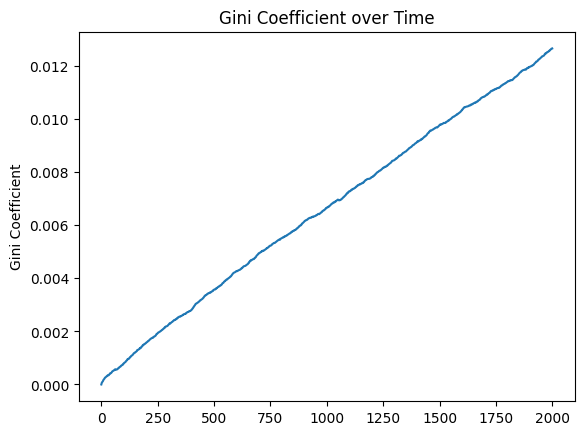

In [94]:
# Plot the Gini coefficient over time
g = sns.lineplot(data=model_data["Gini"])
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [95]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth InitialNeighborhood
Step AgentID                            
0    0           1.0   Non-Discriminated
     1           1.0       Discriminated
     2           1.0   Non-Discriminated
     3           1.0   Non-Discriminated
     4           1.0   Non-Discriminated

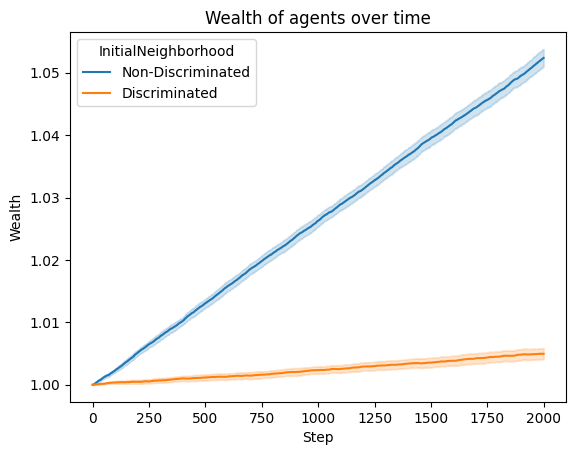

In [96]:
# 1. Collect Agent Wealth Data with Neighborhood Information
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

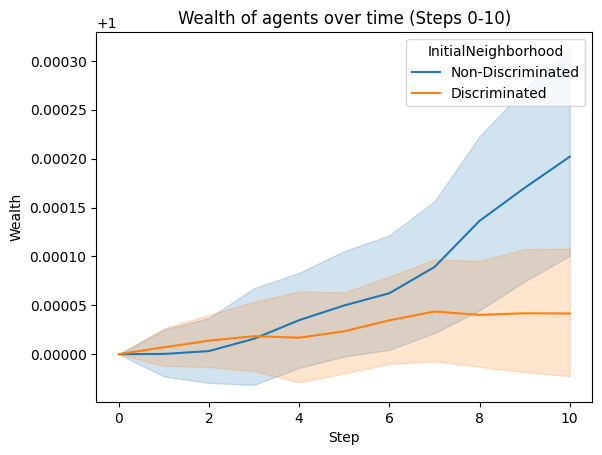

In [97]:
# Filter the data to include only steps l to r
l = 0
r = 10
agent_wealth_zoomed = agent_wealth.loc[(l <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= r)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 0-10)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

# Simulation with Policy Intervention after Step k

In [98]:
k = 10

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods, life_qual_multiplier):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.life_qual_multiplier = life_qual_multiplier
        self.profit_current = 0.01  # Initialize profit_current
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        
        # Check the current step number
        current_step = self.model.schedule.steps
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    # Serve non-discriminated neighborhoods before step n, and everyone after step n
                    if current_step > k or agent.initial_neighborhood != "Discriminated":
                        # Provide service to agents whose initial neighborhood is not discriminated
                        agent.life_quality = math.sqrt(agent.life_quality * (1 + self.life_qual_multiplier))
                        profit += (10*(self.profit_current**2) /(100 + self.profit_current**3))   # Calculate profit for this agent using profit_current
                        cost += 0.001  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)
        self.profit_current += 0.1  # Update profit_current with the profit calculated for this step

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [99]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.0001

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(2000):
    model.step()  # Step the model

/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_43461/2041198889.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


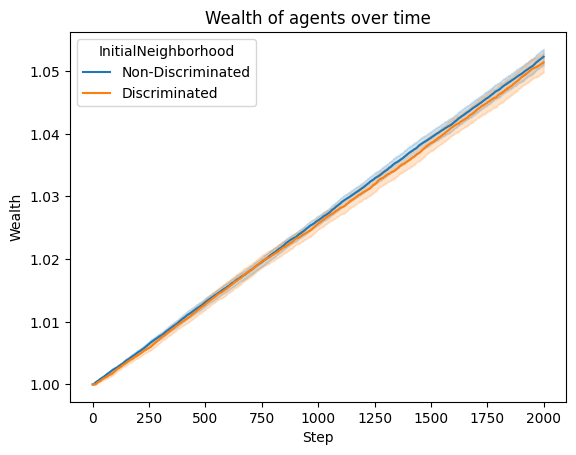

In [100]:
# 1. Collect Agent Wealth Data with Neighborhood Information
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

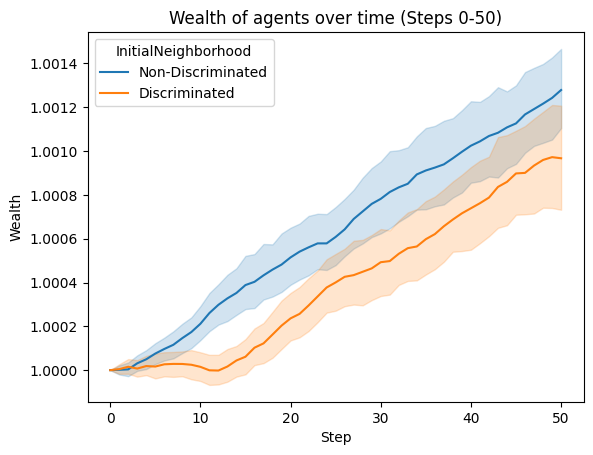

In [101]:
# Filter the data to include only steps l to r
l = 0
r = 50
agent_wealth_zoomed = agent_wealth.loc[(l <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= r)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 0-50)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

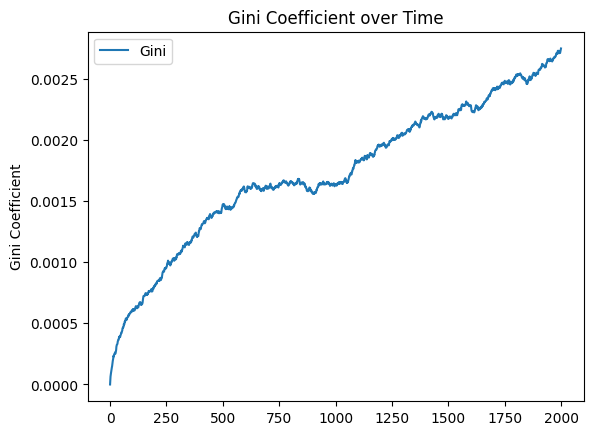

In [102]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");